# PIT for Conditional Flows
Project idea based on [this paper](https://arxiv.org/abs/2102.10473). 

Using the `nflows` library for flow implementations.

## CONTEXT (1D)

Consider the 1D conditional target distribution $f_{\Theta\mid X}$ with **unknown density** and we have **no samples**.

We only have access to samples from the joint distribution $f_{X,\Theta}$: $\quad (\Theta_1,X_1), \dots, (\Theta_n, X_n) \sim f_{X,\Theta}$

Our estimator $f_{Q\mid X}$ is a *Normalizing Flow* whose density is **explicitly known**. It is defined by a base distribution $p_U$ (tipically gaussian) and a bijective transformation $T_{\phi}$: 
$$U\sim p_U \rightarrow Q=T_{\phi}(U, X) \sim f_{Q\mid X}$$ 
$$f_{Q\mid X}(q) = p_{U}\left(T_{\phi}^{-1}(q, X)\right)\left|\operatorname{det} J_{T_{\phi}^{-1}}(q, X)\right|$$ 

Note that we can also define it's c.d.f. explicitly for a fixed $X=x_0$: $\quad F_{Q\mid X=x_0}(q) = \mathbb{P}(Q\leq q \mid X=x_0) =\mathbb{P}(T_{\phi}(U, x_0)\leq q)=\mathbb{P}(U\leq T_{\phi}^{-1}(q, x_0))=F_U(T_{\phi}^{-1}(q, x_0))$

We wish to know evaluate our estimator, with the same method as in the non-conditional case, i.e. with the PIT:

$$\text{PIT}(\theta, x ; f_{Q\mid X}) = \mathbb{P}(Q\leq \theta \mid X=x) = F_{Q \mid X=x}(\theta)$$

## EVALUATION
### True PIT-distribution / Local Consistency
For a fixed $X = x_0$ and $\Theta \sim f_{\Theta \mid X=x_0}$:
$$\begin{align} 
f_{Q\mid x_0} = f_{\Theta\mid x_0} & \iff \text{PIT}(\Theta, x_0 ; f_{Q\mid X})) \sim \mathcal{U}(0,1)\\
& \iff \mathbb{P}_{\Theta \mid x_0}(\text{PIT}(\Theta, x_0 ; f_{Q\mid X})) \leq \alpha) = \alpha, \quad \forall \alpha \in [0,1]\\
& \iff F_{\Theta \mid X=x_0}(F_{Q \mid X=x_0}^{-1}(\alpha)) = \alpha, \quad \forall \alpha \in [0,1]
\end{align}$$

We find ourselves with the same result as in the non-conditional 1D case , as $X$ is fixed at $x_0$ (cf. Theorem 2 in paper). 

**Problem:** We are unable to compute the c.d.f. of the target distribution $F_{\Theta \mid X=x_0}$, as the density $f_{\Theta \mid x_0}$ is unknown and no samples $\theta_i \mid x_0$ are available to approximate it empirically.

### Expected PIT-distribution over $X$ / Global Consistency 
We can however compute the empirical **expected c.d.f. over $X$** by using the samples from the joint distribution. 

$$\begin{align}
\mathbb{E}_X[F_{\Theta\mid X}(F_{Q\mid X}(\alpha)^{-1})] & = \mathbb{E}_X[\mathbb{P}_{\Theta\mid X}(F_{Q\mid X}(\Theta)\leq \alpha)]\\
& = \mathbb{E}_X[\mathbb{E}_{\Theta\mid X}[\mathbb{1}_{\{F_{Q\mid X}(\Theta)\leq \alpha\}}]]\\
& = \mathbb{E}_{\Theta, X}[\mathbb{1}_{\{F_{Q\mid X}(\Theta)\leq \alpha\}}]\\
& \approx \frac{1}{n} \sum_{i=1}^n \mathbb{1}_{\{F_{Q\mid X_i}(\Theta_i)\leq \alpha\}}
\end{align}$$

This gives us an approximation of the **expected (or joint) PIT-distribution:** 

$$\mathbb{E}_X[\mathbb{P}_{\Theta \mid X}(\text{PIT}(\Theta, X ; f_{Q\mid X}) \leq \alpha)] = \mathbb{P}_{\Theta,X}(\text{PIT}(\Theta, X; f_{Q\mid X})\leq \alpha) = \mathbb{E}_{\Theta, X}[\mathbb{1}_{\{F_{Q\mid X}(\Theta)\leq \alpha\}}] \approx \frac{1}{n} \sum_{i=1}^n \mathbb{1}_{\{F_{Q\mid X_i}(\Theta_i)\leq \alpha\}}$$

#### Result 1: 
It is still true that if $\forall X, f_{Q\mid X} = f_{\Theta\mid X} $ (global consistency) and $\Theta, X \sim f_{\Theta, X}$, the *joint PIT-distribution* is uniform:

$$f_{Q\mid X} = f_{\Theta\mid X} \Rightarrow \mathbb{P}_{\Theta,X}(\text{PIT}(\Theta, X; f_{Q\mid X})\leq \alpha) =\alpha, \quad \forall \alpha \in [0,1]$$

**Problem:** The reverse is not true! This quantity does not allow us to evaluate our estimator (i.e. check global concistency) in a reliable way: we can find globally non-consistent estimators ($f_{Q\mid X} \neq f_{\Theta\mid X}$), but whose joint PIT-distribution is uniform. 

#### Result 2: 
Uniformity of the expected PIT-distribution holds for any estimator $f_{Q\mid X} = f_{\Theta\mid g(X)}$ with $g$ a given function (cf. Theorem 1 in paper).

#### Proofs can be found [here](https://notes.inria.fr/s/rhHwKKzaK).

### Global vs. Local Consistency: Illustration via Code 

Let's look at some code to illustrate this.

We consider a target density $\Theta\mid X \sim \mathcal{N}(X_1+X_2, 1)$ with $X = (X_1, X_2) \sim \mathcal{N}(\mu, \Sigma)$ where $\mu = [\mu_1, \mu_2]$ and $\Sigma = \begin{pmatrix} \sigma_{1}^2 & \rho \sigma_1 \sigma_2\\ \rho \sigma_1 \sigma_2 & \sigma_{2}^2 \end{pmatrix}$.



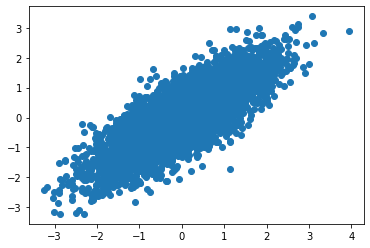

In [672]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch

import torch.distributions as D
from scipy.stats import multivariate_normal, norm

from nde.train import train
from nde.flows import construct_maf
from plot import plot_pdf_1D

# Distribution parameters
mu_1 = 0
mu_2 = 0
sigma_1 = 1
sigma_2 = 1
rho = 0.8

# Distribution of X: 2d gaussian
mean = np.array([mu_1,mu_2])
covariance = np.array([[sigma_1**2, rho*sigma_1*sigma_2],[rho*sigma_1*sigma_2, sigma_2**2]])
x_dist = multivariate_normal(mean=mean, cov=covariance)

# Samples from the conditional distribution P(Theta|X)
n = 5_000 # nb samples 
def get_joint_data(n):
    samples_x = x_dist.rvs(n) # samples from P(X)
    samples_theta = np.array([norm(loc = x[0]+x[1], scale=1).rvs(1) for x in samples_x]) # samples from P(Theta|X)
    return samples_x, samples_theta

samples_x, samples_theta = get_joint_data(n=n)

plt.scatter(samples_x[:,0],samples_x[:,1])
plt.show()

#### Result 1: Uniformity of the expected PIT-distribution

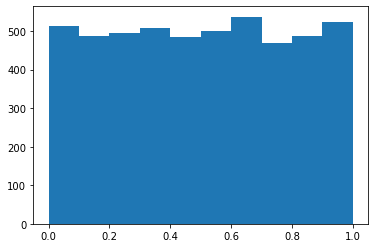

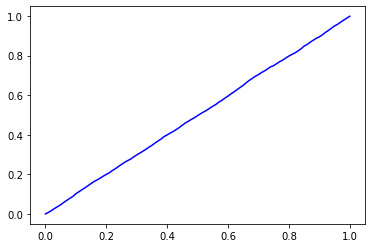

In [491]:
# Plot expected PIT-distribution
Z = np.array(np.mean([norm.cdf(samples_theta, loc=x[0]+x[1], scale=1) for x in samples_x], axis=0)) # E_X[PIT(Theta, X, f_{Theta|X})]
plt.hist(Z)
plt.show()

# Plot pp_plot
alphas = np.linspace(0,0.999,101)
z_true = [np.mean(Z[:,0] < alpha) for alpha in alphas]
plt.plot(alphas, z_true, color='blue')
plt.show()

#### Result 2: Uniformity of globally non-consistent estimators
We consider two NF-estimators:
- good MAF: trained on the full context variable $X=(X_1, X_2)$
- bad MAF: trained on a non-sufficient context $g(X)=X_1$

In [359]:
# Get train, val and test samples: 
# - train samples are used to train the flow, 
# - test samples are used to compute/learn the PIT-distribution 

samples_x, samples_theta = torch.FloatTensor(samples_x), torch.FloatTensor(samples_theta)
test_size = int(0.1 * len(samples_theta))
train_size = len(samples_theta) - test_size
x_train, x_test = samples_x[:train_size], samples_x[train_size:]
theta_train, theta_test = samples_theta[:train_size], samples_theta[train_size:]

print('NB training samples: ', x_train.shape)
print('NB test samples: ', x_test.shape)

NB training samples:  torch.Size([4500, 2])
NB test samples:  torch.Size([500, 2])


In [360]:
# TRAIN FLOWS 

# Good MAF trained on X=(X_1,X_2)
maf_good = construct_maf(theta_train, hidden_features=50, context_features=2, standardize_transform=False)
best_val_loss_good, epochs_good = train(maf_good, theta_train, context=x_train, num_epochs=2000, batch_size=10, lr=0.005, validation=True, plot=False, epochs_until_converge=20)

# Bad MAF trained on g(X)=(X_1)
maf_bad = construct_maf(theta_train, hidden_features=50, context_features=1, standardize_transform=False)
best_val_loss_bad, epochs_bad = train(maf_bad, theta_train, context=x_train[:,0].reshape(-1,1), num_epochs=2000, batch_size=10, lr=0.005, validation=True, plot=False, epochs_until_converge=20)

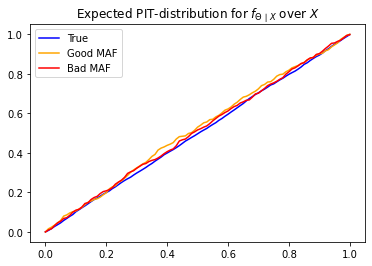

In [492]:
# expected PIT-distribution
cdf_flow = lambda x,context,flow: D.Normal(0,1).cdf(flow._transform(x, context=context)[0])
Z_maf_good = np.array([cdf_flow(theta_test[i][None], context=x, flow=maf_good).detach().numpy() for i,x in enumerate(x_test)]) # [PIT(Theta, X, good)]
Z_maf_bad = np.array([cdf_flow(theta_test[i][None], context=x, flow=maf_bad).detach().numpy() for i,x in enumerate(x_test[:,0].reshape(-1,1))]) # [PIT(Theta, X, bad)]

# Plot pp_plot
alphas = np.linspace(0,0.999,101)
z_maf_good = [np.mean(Z_maf_good[:,0] < alpha) for alpha in alphas]  # [P_X,Theta(Z < alpha)]
z_maf_bad = [np.mean(Z_maf_bad[:,0] < alpha) for alpha in alphas]  # [P_X,Theta(Z < alpha)]

plt.plot(alphas, z_true, color='blue', label='True')
plt.plot(alphas, z_maf_good, color='orange', label='Good MAF')
plt.plot(alphas, z_maf_bad, color='red', label='Bad MAF')
plt.legend()
plt.title(r'Expected PIT-distribution for $f_{\Theta \mid X}$ over $X$')
plt.show()

Both estimators have uniform PIT-distribution, but the bad MAF is not globally consistent. 

Indeed, the code below will show that the bad MAF is locally inconsistent, which implies also that it cannot be globally consistent.

In [728]:
# Samples from the conditional distribution Theta|X=X_0
x_0 = torch.FloatTensor([[0,-1]])
samples_theta_x = torch.FloatTensor(norm(loc = x_0[:,0]+x_0[:,1], scale=1).rvs(test_size)).reshape(-1,1) # samples from P(Theta|X=x_0)
x_0

tensor([[ 0., -1.]])

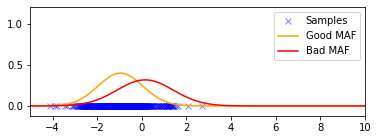

In [729]:
# Plot PDF of trained flows evaluated in x_0
flows = {'Good MAF':(maf_good, x_0, 'orange'), 'Bad MAF':(maf_bad, x_0[:,0], 'red')}
plot_pdf_1D(samples_theta_x, x_i=-5, x_f=10, flows=flows)

We can already see that the two flows disagree. Espcially in the variance. 

This was not represented in the global pp-plot, but can be visualized via the local pp-plot (see code below).

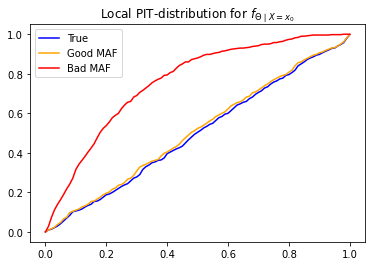

In [730]:
# local PIT-distribution
Z_x = norm.cdf(samples_theta_x, loc=x_0[:,0]+x_0[:,1], scale=1) # [PIT(Theta, X, f_{Theta|X})]
Z_maf_good_x = cdf_flow(samples_theta_x, context=x_0, flow=maf_good).detach().numpy() # [PIT(Theta, X=x_0, good]
Z_maf_bad_x = cdf_flow(samples_theta_x, context=x_0[:,0], flow=maf_bad).detach().numpy() # [PIT(Theta, X=x_0, bad]

# Plot pp_plot
np.linspace(0,0.999,101)
z_true_x = [np.mean(Z_x[:,0] < alpha) for alpha in alphas]  # [P_Theta|X(Z < alpha)]
z_maf_good_x = [np.mean(Z_maf_good_x[:,0] < alpha) for alpha in alphas]  # [P_Theta|X(Z < alpha)]
z_maf_bad_x = [np.mean(Z_maf_bad_x[:,0] < alpha) for alpha in alphas]  # [P_Theta|X(Z < alpha)]

plt.plot(alphas, z_true_x, color='blue', label='True')
plt.plot(alphas, z_maf_good_x, color='orange', label='Good MAF')
plt.plot(alphas, z_maf_bad_x, color='red', label='Bad MAF')
plt.legend()
plt.title(r'Local PIT-distribution for $f_{\Theta \mid X=x_0}$')
plt.show()

Indeed, the variance distorsion of the bad MAF is clearly visible in this pp-plot (red line in S-shape). 

This shows that if our function $g(X)$ doas not caracterize covariate relations between the elements of $X$ (e.g. non-sufficient summary statistics), the expected PIT-distribution will not show us the error, whereas the local PIT-distribution does.

We need a way to claculate the local PIT-distribution! 

## Estimating the Local PIT-Distribution

We define the $\alpha$-quantile of the local PIT-distribution as follows:

$$ r_{\alpha}(X) = \mathbb{P}_{\Theta \mid X}(\text{PIT}(\Theta, X ; f_{Q\mid X}) \leq \alpha) = \mathbb{E}[\mathbb{1}_{\{\text{PIT}(\Theta, X ; f_{Q\mid X}) \leq \alpha\}}]$$

### Method proposed by [[Zhao et. al, UAI 2021]](https://arxiv.org/abs/2102.10473): 
**Regression of $W^{\alpha} = \mathbb{1}_{\{\text{PIT}(\Theta, X ; f_{Q\mid X}) \leq \alpha\}}$ on $X$, using samples from the joint $(\Theta_i, X_i) \sim f_{\Theta, X}$.**

The goal is to estimate the random variable $W^{\alpha}$ as a function $f$ of $X$. 

Theoretically, the optimal solution of this regression problem - in terms of $L^2$-distance $E\left[(W^{\alpha} - f(X))^2\right]$ - is the conditional expectation $f^{\star}(X) = \mathbb{E}[W^{\alpha} \mid X] = r_{\alpha}(X)$ (it corresponds to the othogonal projection of $W^{\alpha}$ on $L^2(\Omega, \mathcal{F}(X), \mathbb{P}) = L^2_X$).

#### Algorithm:
1. pre-compute $W^{\alpha}_i$ using the avalable samples $\Theta_i, X_i$
2. regress $W^{\alpha}_i$ on $X_i$ to get an estimate of $r_{\alpha}(X)$
3. evaluate $r_{\alpha}$ in $X=x_0$
4. plot $r_{\alpha}(x_0)$ as a function of $\alpha$ and compare to identity

#### Comments
- This is actually a binary classifiacation problem 
- We need to use a regressor / classifier that has an optimum defined by the conditional expectation! 
- Different loss function (i.e. classifiers) can be used (cf. [On Loss Functions Which Minimii to Conditional Expected Values and Posterior Probabilities](https://authors.library.caltech.edu/93850/1/00243457.pdf))
- There is a monotonic coupling / ordering between $r_{\alpha}(X)$ and $\alpha$: $r_{\alpha}(X) \nearrow \alpha$
    - cf. [isotonic regression with monotonic constraint in sklearn](https://scikit-learn.org/stable/modules/isotonic.html) (//calibration with binary target variable)
    - what about the multivariate case? cf. Random Forest for multi-output with monotonic splitting criteria?
    - implement existing method and analyse if monotonic or not in $\alpha$


### Implementation of the Regression Method

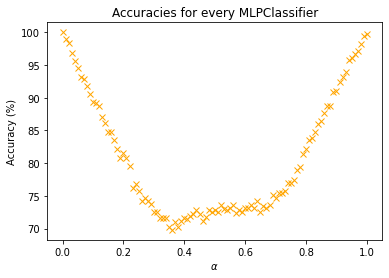

Mean training accuracy:  80.83


In [731]:
# import classifiers 
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.isotonic import IsotonicRegression

# LogisticRegression(penalty='none', solver='saga', max_iter=10000)
# MLPClassifier(alpha=0, max_iter=25000)

theta_train_PIT = theta_test
x_train_PIT = x_test

pit_values_train_good = np.array([cdf_flow(theta_train_PIT[i][None], context=x, flow=maf_good).detach().numpy() for i,x in enumerate(x_train_PIT)]) # [PIT(Theta, X, good)]
pit_values_train_bad = np.array([cdf_flow(theta_train_PIT[i][None], context=x, flow=maf_bad).detach().numpy() for i,x in enumerate(x_train_PIT[:,0].reshape(-1,1))]) # [PIT(Theta, X, bad)]

alphas = np.linspace(0,0.999,101)
pit_values_train = pit_values_train_bad[:,0]
x_eval = x_0.numpy()

r_alpha_test = {}
accuracies = {}
for alpha in alphas:
    W_a_train = np.array([1*(z <= alpha) for z in pit_values_train])
    clf = MLPClassifier(alpha=0, max_iter=25000)
    clf.fit(X=x_train_PIT.numpy(), y=W_a_train.ravel())
    accuracies[alpha] = clf.score(x_train_PIT.numpy(), W_a_train.ravel())*100
    r_alpha_test[alpha] = clf.predict_proba(x_eval)[:,1][0]

accuracies = pd.Series(accuracies)
accuracies.plot(style='x', color='orange')
plt.title(r'Accuracies for every MLPClassifier')
plt.xlabel(r'$\alpha$')
plt.ylabel('Accuracy (%)')
plt.show()
print('Mean training accuracy: ', np.round(np.mean(accuracies),3))

Accuracy drops in the middle range between $\alpha = 0.2$ and $\alpha = 0.8$. 
But this is the range that interests us most! 
Indeed, at the extrems (0 and 1) it will always be 100% correct because only one class is present. 

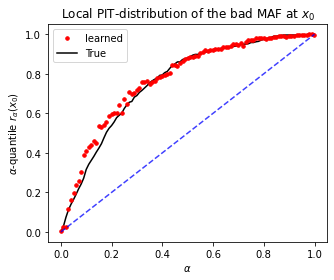

Euclidean Distance to empirical local pit-distribution (ground-truth):  0.333


In [732]:
# Plot pp-plot
r_alpha_test = pd.Series(r_alpha_test)
fig = pd.Series(r_alpha_test).plot(style='.', color='red', figsize=(5,4), markersize=7, label='learned')
plt.plot(alphas, z_maf_bad_x, color='black', label='True', zorder=0)
lims = [np.min([0,0]), np.max([1,1]),]
plt.plot(lims, lims, 'b--', alpha=0.75)
plt.ylabel(r'$\alpha$-quantile $r_{\alpha}(x_0)$')
plt.xlabel(r'$\alpha$')
plt.legend()
plt.title(r'Local PIT-distribution of the bad MAF at $x_0$')
plt.show()

euc_dist_to_gt = math.dist(z_maf_bad_x, list(r_alpha_test.values))
print('Euclidean Distance to empirical local pit-distribution (ground-truth): ', np.round(euc_dist_to_gt,3))

In [733]:
# check monotonicity of r_alpha
monotonicity = np.mean([x<=y for x, y in zip(list(r_alpha_test.values), list(r_alpha_test.values[1:]))])
print(f'{monotonicity*100}% of the points agree with the constraint that the alpha-quantile has to be increasing with alpha.')

75.0% of the points agree with the constraint that the alpha-quantile has to be increasing with alpha.


Errors:
- logisticregressor doesnt work because needs 2 classes in training data. 
- Isotonic regression doesn't work because 'input X should be a 1d array or 2d array with 1 feature'. Anyway it should be increasing with alpha and not x.
- if including 1 in the alphas list, we get an outlier in the prediction

Comments:
- MLP trained for classification with the `log_loss`: $L_{\log }(y, p)=-(y \log (p)+(1-y) \log (1-p))$
- $p=$`predict_proba[:,1]` gives the probability of the **class $1$**, the success class of being $\leq \alpha$
- the classifiers are less accurate in the middle range, which is exactly where the most interesting information lies. 
    - Is there a way to increase this accuracy? maybe with the increaing constraint? 
    - Confidence-bands can also help. 

Ideas:
- regressor on alpha and X, can make isotonic only on one variable? converges to what theoretically? 


### Amortized in alpha 

#### all alphas 

In [742]:
# train features alpha and x 
x_train_alphas = np.array([i for i in x_train_PIT.numpy()]*101)
alphas_train = np.linspace(0,0.999,101).repeat(test_size).reshape(-1,1)
train_features_all = np.concatenate([x_train_alphas, alphas_train], axis=1)

# train labels W_alpha(z)
W_a_train_all = []
alphas = np.linspace(0,0.999,101).reshape(-1,1)
for alpha in alphas:
    W_a_train_all.append(np.array([1*(z <= alpha) for z in pit_values_train]))
W_a_train_all = np.array(W_a_train_all).flatten()

In [743]:
# Train calssifier amortized on x and alpha 
clf = MLPClassifier(alpha=0., max_iter=25000)
clf.fit(X=train_features_all, y=W_a_train_all)
train_accuracy = clf.score(train_features_all, W_a_train_all.ravel())*100

In [744]:
# Evaluate in x_0 and for all alphas in [0,1]
r_alpha_test_all = {}
for alpha in np.linspace(0,0.999, 101):
    test_features = np.concatenate([x_eval, np.array(alpha).reshape(-1,1)], axis=1)
    r_alpha_test_all[alpha] = clf.predict_proba(test_features)[:,1][0]

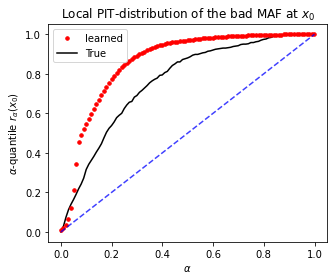

Training accuracy:  82.699
Euclidean Distance to empirical local pit-distribution (ground-truth):  1.351


In [745]:
# Plot pp-plot
r_alpha_test_all = pd.Series(r_alpha_test_all)
fig = r_alpha_test_all.plot(style='.', color='red', figsize=(5,4), markersize=7, label='learned')
plt.plot(alphas, z_maf_bad_x, color='black', label='True', zorder=0)
lims = [np.min([0,0]), np.max([1,1]),]
plt.plot(lims, lims, 'b--', alpha=0.75)
plt.ylabel(r'$\alpha$-quantile $r_{\alpha}(x_0)$')
plt.xlabel(r'$\alpha$')
plt.legend()
plt.title(r'Local PIT-distribution of the bad MAF at $x_0$')
plt.show()
print('Training accuracy: ', np.round(train_accuracy,3))

import math
euc_dist_to_gt_all = math.dist(z_maf_bad_x, list(r_alpha_test_all.values))
print('Euclidean Distance to empirical local pit-distribution (ground-truth): ', np.round(euc_dist_to_gt_all,3))

In [738]:
# check monotonicity of r_alpha
monotonicity = np.mean([x<=y for x, y in zip(list(r_alpha_test_all.values), list(r_alpha_test_all.values[1:]))])
print(f'{monotonicity*100}% of the points agree with the constraint that the alpha-quantile has to be increasing with alpha.')

100.0% of the points agree with the constraint that the alpha-quantile has to be increasing with alpha.


#### samples of alpha

In [739]:
alphas_sample = np.random.rand(test_size).reshape(-1,1)
train_features_sample = np.concatenate([x_train_PIT.numpy(), alphas_sample], axis=1)
    

W_a_train_sample = np.array([1*(z <= alphas_sample[i]) for i,z in enumerate(pit_values_train)])
clf = MLPClassifier(alpha=0, max_iter=25000)
clf.fit(X=train_features_sample, y=W_a_train_sample.ravel())
train_accuracy_sample = clf.score(train_features_sample, W_a_train_sample.ravel())*100

r_alpha_test_sample = {}
for alpha in np.linspace(0,0.999,101):
    test_features = np.concatenate([x_eval, np.array(alpha).reshape(-1,1)], axis=1)
    r_alpha_test_sample[alpha] = clf.predict_proba(test_features)[:,1][0]

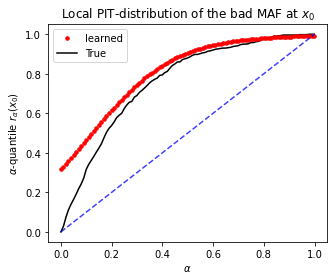

Training accuracy:  80.6
Euclidean Distance to empirical local pit-distribution (ground-truth):  0.899


In [740]:
# Plot pp-plot
r_alpha_test_sample = pd.Series(r_alpha_test_sample)
fig = r_alpha_test_sample.plot(style='.', color='red', figsize=(5,4), markersize=7, label='learned')
plt.plot(alphas, z_maf_bad_x, color='black', label='True', zorder=0)
lims = [np.min([0,0]), np.max([1,1]),]
plt.plot(lims, lims, 'b--', alpha=0.75)
plt.ylabel(r'$\alpha$-quantile $r_{\alpha}(x_0)$')
plt.xlabel(r'$\alpha$')
plt.legend()
plt.title(r'Local PIT-distribution of the bad MAF at $x_0$')
plt.show()
print('Training accuracy: ', np.round(train_accuracy_sample,3))

euc_dist_to_gt_sample = math.dist(z_maf_bad_x, list(r_alpha_test_sample.values))
print('Euclidean Distance to empirical local pit-distribution (ground-truth): ', np.round(euc_dist_to_gt_sample,3))

In [741]:
# check monotonicity of r_alpha
monotonicity = np.mean([x<=y for x, y in zip(list(r_alpha_test_sample.values), list(r_alpha_test_sample.values[1:]))])
print(f'{monotonicity*100}% of the points agree with the constraint that the alpha-quantile has to be increasing with alpha.')

100.0% of the points agree with the constraint that the alpha-quantile has to be increasing with alpha.


Comments:
- the original method with multiple classifiers (one for each alpha value) seems to be better in terms of euclidean distance 
- it is not verifying the monotonic constraint which sometimes leads to big distances to the groundtruth
- the in alpha amortized versions insure that the monotonic constrain is respected 
- but depending on the $x_0$ used for evaluation, the amortized versionsx can be pretty far from the black groundtruth (euclidean distance)


In [676]:
torch.FloatTensor([[-2,-2]]) in x_test

False